# Project 2: Improvements to FX Mean Reversion Strategy
## 1. Research Question
Now that we have a basic strategy, let's explore some improvements to this strategy. In this article, we mainly want to explore the following improvements:
- Using exponential weighted averages rather than moving averages
- Changing the strategy to trade proportional to the Z-score, rather than using a constant amount throughout
- Adding another signal to the mix to see if we can use cointegration

## 2. Baseline results
Let's pull up the data and run the same trading strategy as in the Part 1 article, to obtain our baseline results. The algorithm is straightforward - we found that the GBP-EUR exchange rate was mean reverting between 2016 to 2019 based on the ADF test using daily close data. Using this information, we used a 51-day moving average window combined with a Z-score algorithm:
$$Z_t = \frac{(X_t - \mu_t)}{\sigma_t}$$
where $X_t$ denotes the signal, $\mu_t$ denotes the moving average, and $\sigma_t$ denotes the moving standard deviation.
Based on this Z-score, we proposed a trading algorithm based on the the absolute value of the Z-score exceeding a critical value. 

In [1]:
########## IMPORTS AND DEFINITIONS
import numpy as np
import pandas as pd
import yfinance as yf
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Define trading function
def trade_size(algo_type, z, trd_size):
    # algo_type == True for constant trade size, False for proportional trade size
    if algo_type:
        return trd_size
    else:
        return trd_size * abs(z)
        
def run_trading(data, test_window_start, test_window_end, weights, z_crit, eur_pos, gbp_pos, trd_size, lookback, algo_type=True):
    df = data.iloc[test_window_start:test_window_end]
    y = np.array([y[0] for y in df['Close'].dropna().values.tolist()])
    t = df.index.tolist()

    rolling_mean = np.array([np.dot(y[i-lookback:i], weights) for i in range(lookback, len(y))])
    rolling_std  = np.array([np.std(y[i-lookback:i]) for i in range(lookback, len(y))])

    eur_val = [eur_pos]
    gbp_val = [gbp_pos]
    total_val = [eur_pos + gbp_pos * y[lookback-1]]

    z_score_prev = (y[lookback-1] - rolling_mean[0])/rolling_std[0]
    exited = False
    for i in range(lookback, len(y)):
        mu = rolling_mean[i-lookback]
        sigma = rolling_std[i-lookback]
        z_score = (y[i] - mu)/sigma

        if z_score >= z_crit:
            # GBP doing too well, and it's about to mean revert, so sell GBP
            ts = trade_size(algo_type, z_score, trd_size)
            eur_pos = eur_pos + ts
            gbp_pos = gbp_pos - ts * y[i]
            exited = False
        elif z_score <= -z_crit:
            # GBP doing too badly, and it's about to mean revert, so buy GBP
            ts = trade_size(algo_type, z_score, trd_size)
            eur_pos = eur_pos - ts
            gbp_pos = gbp_pos + ts * y[i]
            exited = False
        else:
            pass
        eur_val.append(eur_pos)
        gbp_val.append(gbp_pos)
        total_val.append(eur_pos + gbp_pos * y[i])
        
    # Sharpe Ratio
    returns = np.array([(total_val[i]-total_val[i-1])/total_val[i-1] for i in range(1,len(total_val))])
    N_period = 252
    risk_free_rate = 0.04 / N_period # 4 percent converted to daily rate
    ret_mean = np.mean(returns)
    ret_std = np.std(returns)
    sharpe_ratio = (ret_mean - risk_free_rate)/ret_std * np.sqrt(N_period)
    
    # Annualized return
    N_years = (test_window_end-test_window_start)/365
    abs_return = (total_val[-1]-total_val[0])/total_val[0]
    annualized_return = (1+abs_return)**(1/N_years) - 1

    return returns, sharpe_ratio, annualized_return, rolling_mean, t, y, total_val

In [2]:
# Example: Get EUR/CHF data
data = yf.download("EURGBP=X", start='2005-08-21', end='2025-08-21', interval='1d', auto_adjust=True)

# Trading params
lookback = 51  # half-life
test_window_start = 2700
test_window_end = 3500
z_crit = 1.0
eur_pos = 100
gbp_pos = 100
trd_size = 5

returns, sharpe_ratio, annualized_return, rolling_mean_simple, t, y, tv = run_trading(data, test_window_start, test_window_end, [1/lookback]*lookback, z_crit, eur_pos, gbp_pos, trd_size, lookback)
print('Sharpe Ratio = ', sharpe_ratio)
print('Annualized Returns in Percentage = ', annualized_return * 100)

[*********************100%***********************]  1 of 1 completed

Sharpe Ratio =  1.8932711883588738
Annualized Returns in Percentage =  28.78745004723884


# First improvement: Weighted moving average
The simple moving average that we've used above uses equal weights for all points in the 51-day moving average window. Instead, we propose using an exponential weighted average, where the weights decay geometrically by a factor $0 < \alpha < 1$:

$$\begin{align}
\mu_{i} &= \frac{1}{W} \left[ x_i + \alpha x_{i-1} + \alpha^2 x_{i-2} + ... + \alpha^n x_{i-n} \right] \\
\text{where } W &\coloneqq \sum_{j=0}^n \alpha^j = \frac{(1-\alpha^{n+1})}{(1-\alpha)}
\end{align}$$

It's important that for any moving average, the weights must sum up to 1 in order to maintain the unbiased nature of the estimator; hence the leading $1/W$ factor. Let's compute the exponential moving average and compare it to the simple moving average.

Alpha =  1.0
Sharpe Ratio =  1.8932711883588738
Annualized Returns in Percentage =  28.78745004723884 

Alpha =  0.95
Sharpe Ratio =  0.46724972040536833
Annualized Returns in Percentage =  9.97622658970414 

Alpha =  0.9
Sharpe Ratio =  0.0814459602049682
Annualized Returns in Percentage =  6.038398651589505 

Alpha =  0.8
Sharpe Ratio =  -0.07665312124167079
Annualized Returns in Percentage =  4.6283180038212635 

Alpha =  0.6
Sharpe Ratio =  -0.29449622184453406
Annualized Returns in Percentage =  2.5173528605944906 



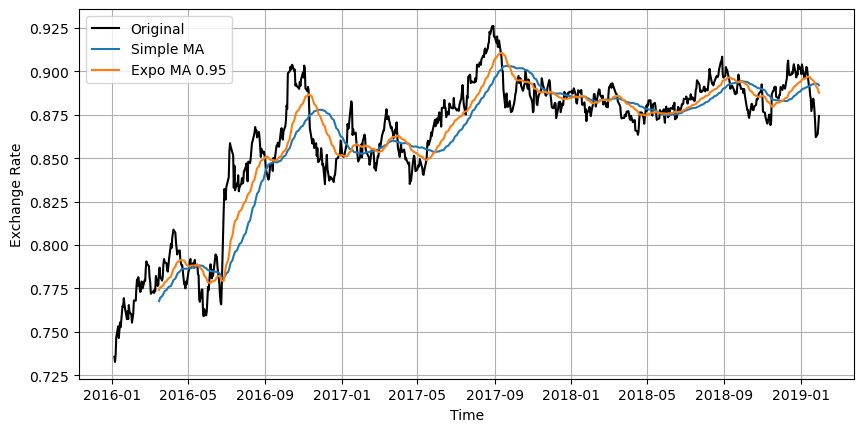

In [3]:
# Compute weights and have them ready
alphas = [1.0, 0.95, 0.9, 0.8, 0.6]
for alpha in alphas:
    weights = [alpha**i for i in range(lookback)]
    weight_total = sum(weights)
    weights = [w/weight_total for w in weights]
    weights = weights[-1::-1] # Invert order so it matches histortical data

    # With nothing else changed other than weights, how does the algorithm fare?
    returns, sharpe_ratio, annualized_return, rolling_mean, t, y, tv = run_trading(data, test_window_start, test_window_end, weights, z_crit, eur_pos, gbp_pos, trd_size, lookback)
    print('Alpha = ', alpha)
    print('Sharpe Ratio = ', sharpe_ratio)
    print('Annualized Returns in Percentage = ', annualized_return * 100, '\n')

    if alpha == 0.95:
        rolling_mean_expo= rolling_mean
        weights_test = weights
    
# plot means
f = plt.figure(1)
plt.plot(t, y, color='black')
plt.plot(t[lookback:], rolling_mean_simple)
plt.plot(t[lookback:], rolling_mean_expo)
plt.legend(['Original', 'Simple MA', 'Expo MA 0.95'])
plt.xlabel('Time')
plt.ylabel('Exchange Rate')
plt.grid()
f.set_figwidth(10)

Looks like we don't really stand to gain much from using exponential moving averages in comparison to a simple moving average. To understand why, we look at the plot above Even changing $\alpha$ from 1.0 (for simple moving average) to 0.95 makes the exponential moving average curve resemble the original curve much more closely. We most likely have far fewer trading signals because the signal exceeds the critical Z-score far more rarely. That already gives us some intuition of where to look for an improvement - the ciritcal Z-score. Given that the exponential moving average is intended to more closely follow the signal and with less lag, we can try with a lower critical Z-score. From the test below, we can see that lowering the Z-score for $\alpha = 0.95$ leads to significant performance gain, but the performance begins to drop off after 0.25. Additionally, trading frequency also becomes higher the narrower the critical window becomes, leading to higher costs (not factored here).

In [4]:
for z_crit in [1.0, 0.5, 0.25, 0.125, 0.0625]:
    returns, sharpe_ratio, annualized_return, rolling_mean, t, y, tv = run_trading(data, test_window_start, test_window_end, weights_test, z_crit, eur_pos, gbp_pos, trd_size, lookback)
    print('Z-crit = ', z_crit)
    print('Sharpe Ratio = ', sharpe_ratio)
    print('Annualized Returns in Percentage = ', annualized_return * 100, '\n')

Z-crit =  1.0
Sharpe Ratio =  0.46724972040536833
Annualized Returns in Percentage =  9.97622658970414 

Z-crit =  0.5
Sharpe Ratio =  1.4902129661421506
Annualized Returns in Percentage =  23.823541921278935 

Z-crit =  0.25
Sharpe Ratio =  1.8391385444329453
Annualized Returns in Percentage =  30.787527607535804 

Z-crit =  0.125
Sharpe Ratio =  1.7543783061966114
Annualized Returns in Percentage =  30.59980471439754 

Z-crit =  0.0625
Sharpe Ratio =  1.6787185793404291
Annualized Returns in Percentage =  29.625056547199602 



Any good strategy development should have hyper-parameter optimization in it to select appropriate values of these parameters. But since this is all purely academic, I'm taking several liberties here to better demonstrate the intuition behind tuning certain specific parameters. On to the next strategy improvement!

# Second improvement: Trade proportional to Z-score
In the base strategy, we traded a fix amount whenever we would get a buy or sell signal. In the improved strategy, we trade an amount proportional to the Z-score. That way, larger departures are leveraged more, and vice-versa. For the sake of simplicity, we'll assume that a simple moving average is used. As can be seen from the plots and numbers below, we get a significant improvement in returns with minimal change in Sharpe ratio, naturally depending on our choice of how we scale the Z-score. An important point to note here is that Sharpe Ratio and returns keep improving as we increase the proportionality constant. This of course shouldn't be misread as "trade as big a position as possible when the going is good", naturally because we don't know when the going is good and when it isn't. The proportionality should reflect your confidence in the signal.

In [5]:
# Returns for baseline constant trade size strategy
z_crit = 1.0
trd_size = 5.0
algo_type = True
returns, sharpe_ratio, annualized_return_const, _, t, _, tv_const = run_trading(data, test_window_start, test_window_end, [1/lookback]*lookback, z_crit, eur_pos, gbp_pos, trd_size, lookback, algo_type)
print('Contrant Trade Size:')
print('Sharpe Ratio = ', sharpe_ratio)
print('Annualized Returns in Percentage = ', annualized_return_const * 100, '\n')

# Returns for proportional strategy
algo_type = False
for trd_size in [1.0, 2.0, 4.0, 8.0, 16.0]:
    returns, sharpe_ratio, annualized_return_prop, _, t, _, tv_prop = run_trading(data, test_window_start, test_window_end, [1/lookback]*lookback, z_crit, eur_pos, gbp_pos, trd_size, lookback, algo_type)
    print('Proportional Trade Size: ', trd_size)
    print('Sharpe Ratio = ', sharpe_ratio)
    print('Annualized Returns in Percentage = ', annualized_return_prop * 100)

Contrant Trade Size:
Sharpe Ratio =  1.8932711883588738
Annualized Returns in Percentage =  28.78745004723884 

Proportional Trade Size:  1.0
Sharpe Ratio =  1.3495462661017112
Annualized Returns in Percentage =  12.853089392432015
Proportional Trade Size:  2.0
Sharpe Ratio =  1.7495710322884228
Annualized Returns in Percentage =  22.215338754230295
Proportional Trade Size:  4.0
Sharpe Ratio =  1.895018087215961
Annualized Returns in Percentage =  38.74580822655271
Proportional Trade Size:  8.0
Sharpe Ratio =  2.0209847312513416
Annualized Returns in Percentage =  66.20106067731295
Proportional Trade Size:  16.0
Sharpe Ratio =  2.1350496070351808
Annualized Returns in Percentage =  109.07229741038869
